In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import time
from torch.optim.lr_scheduler import StepLR

from transformers import AutoFeatureExtractor, ASTForAudioClassification, AutoConfig
from datasets import load_dataset
import soundfile
import librosa
from transformers import ASTConfig, ASTModel
from tqdm import tqdm


In [10]:
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")

In [11]:
high = 1
low = -1
sample_size = 10000
sequence_size = 1000
degree = 3
x = torch.linspace(-1, 1, sequence_size)
x = x.unsqueeze(1).expand(sequence_size, sample_size)
y = torch.zeros_like(x)
for n in range(degree):
    p = (high - low) * torch.rand(sample_size)
    y += p*(x**(n+1))

#plt.plot(x[:,0], y[:,0]);
print(y.shape)

torch.Size([1000, 10000])


In [5]:
'''y_np = y.numpy()
y_np = y_np/np.max(np.abs(y_np))
sample_y = y_np[:, 0]
D = librosa.stft(sample_y, n_fft=2032, hop_length=8)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
spectrogram = np.expand_dims(S_db, axis=0)
spectrogram = torch.tensor(spectrogram).to(device)
print(spectrogram.shape)'''

torch.Size([1, 1017, 126])


In [12]:
y_np = y.numpy().swapaxes(0,1)
y_np = y_np/np.max(np.abs(y_np))

def to_spectrogram(data, n_fft=2032, hop_length=8):
    D = librosa.stft(data, n_fft=n_fft, hop_length=hop_length)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    spectrogram = np.expand_dims(S_db, axis=0)
    return torch.tensor(spectrogram)

In [13]:
dataloader = DataLoader(y_np, batch_size=100)
all_spectrograms = []

for batch in tqdm(dataloader):
    batch = batch.numpy()
    batch_spectrograms = [to_spectrogram(s) for s in batch]
    batch_tensor = torch.vstack(batch_spectrograms)
    all_spectrograms.append(batch_tensor)    

  0%|          | 0/100 [00:00<?, ?it/s]/home/cymberly/miniconda3/envs/multifunc/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2032 is too large for input signal of length=1000
  warnings.warn(
100%|██████████| 100/100 [07:38<00:00,  4.59s/it]


In [6]:
all_spectrograms = torch.vstack(all_spectrograms).to(device)

100


In [7]:
all_spectrograms.shape

torch.Size([10000, 1017, 126])

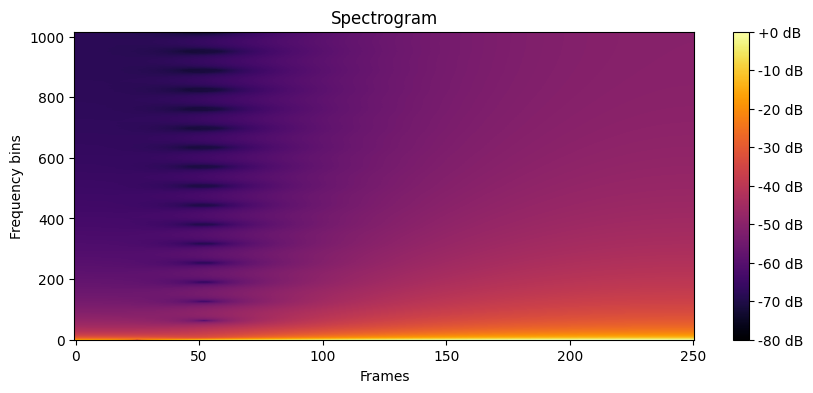

In [18]:
r = np.random.randint(1000)
spectrogram_np = data[r].cpu().numpy().squeeze()

plt.figure(figsize=(10, 4))
plt.imshow(spectrogram_np, aspect='auto', origin='lower', cmap='inferno')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.xlabel('Frames')
plt.ylabel('Frequency bins')
plt.show()

In [5]:
def linear_function(params, x, device):
    x = x.to(device)
    if params.size(1) > 1:
        a = params[:, 0].type(torch.float).unsqueeze(1).to(device)
        b = params[:, 1].type(torch.float).unsqueeze(1).to(device)
        return a*x + b
    else:
        return torch.zeros_like(params)

def quadratic_function(params, x, device):
    params = params.to(device)
    x = x.to(device)
    y = torch.zeros((params.size(0),x.shape[0])).to(device)
    if params.size(1) > 2:
        for n in range(len(params[0])):
            y += (params[:, n].type(torch.float).unsqueeze(1).to(device))*x**(3-n)
        return y
    else:
        return torch.zeros_like(params)

def cubic_function(params, x, device):
    params = params.to(device)
    x = x.to(device)
    y = torch.zeros((params.size(0),x.shape[0])).to(device)
    if params.size(1) > 3:
        for n in range(len(params[0])):
            y += (params[:, n].type(torch.float).unsqueeze(1).to(device))*x**(3-n)
        return y
    else:
        return torch.zeros_like(params)
    
def sin_function(params, x, device):
    x = x.to(device)
    if params.size(1) == 3:
        amplitude = params[:, 0].type(torch.float).unsqueeze(1).to(device)
        frequency = params[:, 1].type(torch.float).unsqueeze(1).to(device)
        phase = params[:, 2].type(torch.float).unsqueeze(1).to(device)
        return amplitude * torch.sin(2 * torch.pi * frequency * x + phase)
    else:
        return torch.zeros_like(x)

In [7]:
def new_loss(output, target, x):
    derivative_true = torch.autograd.grad(outputs=target.requires_grad_(True), inputs=x, grad_outputs=torch.ones_like(target), allow_unused=True)[0]
    if derivative_true is None:
        derivative_true = torch.zeros_like(output)
    derivative_pred = (torch.roll(output, shifts=-1, dims=0) - torch.roll(output, shifts=1, dims=0)) / (2 * 1e-8)
    mse_function = torch.mean(torch.abs(target - output)**3)
    mse_derivative = torch.mean(torch.abs(derivative_pred - derivative_true)**3)
    return mse_function + mse_derivative

In [9]:
class CustomModel(ASTForAudioClassification):
    def __init__(self, config, functions, x_data, device):
        super().__init__(config)
        self.device = device
        self.functions = functions
        self.x_data = x_data
        self.params = sum(self.functions[1])
        
        del self.classifier.dense

        self.flatten_layer = nn.Flatten()

        self.hidden_embedding = nn.Sequential(
            nn.Linear(28, 128),
            nn.SELU(),
            nn.Linear(128, 64),
            nn.SELU(),
            nn.Linear(64, self.params),
        )

    def forward(self, input_values):
        outputs = self.audio_spectrogram_transformer(input_values)
        output = self.classifier.layernorm(outputs[0])
        print(f"outputs: {outputs.shape}")
        embedding = self.hidden_embedding(outputs)
        
        return output

In [10]:
config = ASTConfig()
functions = [[linear_function, quadratic_function, cubic_function, sin_function], [2,3,4,3]]
customModel = CustomModel(config, functions=functions, x_data=x).to(device)

NameError: name 'x' is not defined

In [6]:
loss_func = nn.MSELoss()
optimizer = optim.Adam(customModel.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
training_data = DataLoader(data, batch_size=10)

In [7]:
epochs = 1
for epoch in range(epochs):
    start_time = time.time()
    train_loss = 0.0
    total_num = 0
    customModel.train()
    
    for train_batch in training_data:
        out = customModel(train_batch)


In [8]:
customModel.train
print(data[0].unsqueeze(0).shape)
outs = customModel(data[0].unsqueeze(0))
print(outs.shape)

torch.Size([1, 1017, 126])
torch.Size([1, 1214, 768])


In [9]:
dummyData = torch.zeros((10, 1017, 128)).to(device)
print(dummyData.shape)
customModel(dummyData).shape

torch.Size([10, 1017, 128])


torch.Size([10, 1214, 768])

In [ ]:
'''r = np.random.randint(sample_size)
sample = data[r, :, 0]
print(sample.shape)
# STFT parameters
n_fft = 256  # Number of FFT components
win_length = 256  # Window length
hop_length = 128  # Number of samples between frames

# Convert sample to complex tensor with the required dimensions
sample = sample.unsqueeze(0)  # Add batch dimension

# Apply STFT
spectrogram = torch.stft(sample, n_fft=n_fft, win_length=win_length, hop_length=hop_length, return_complex=True)
print(spectrogram.shape)
# Compute magnitude spectrogram
magnitude_spectrogram = torch.abs(spectrogram)
print(magnitude_spectrogram.shape)

# Convert to numpy for plotting
spectrogram_np = magnitude_spectrogram.squeeze().cpu().numpy()
print(spectrogram_np.size)
# Plot the spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(20 * np.log10(spectrogram_np + 1e-8), aspect='auto', origin='lower', cmap='inferno')
plt.colorbar(label='Magnitude (dB)')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Spectrogram of Polynomial Function Output')
plt.show()

plt.plot(data[r, :, 0].detach().cpu().numpy(), "-");
'''

In [ ]:
dataset = load_dataset("hf-internal-testing/librispeech_asr_demo", "clean", split="validation", trust_remote_code=True)
dataset = dataset.sort("id")
sampling_rate = dataset.features["audio"].sampling_rate

feature_extractor = AutoFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
model = ASTForAudioClassification.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

inputs = feature_extractor(dataset[0]["audio"]["array"], sampling_rate=sampling_rate, return_tensors="pt")
print(inputs['input_values'].shape)
#print(**inputs)
with torch.no_grad():
    #logits = model(**inputs).logits
    logits = model(inputs["input_values"]).logits

print(logits.shape)

predicted_class_ids = torch.argmax(logits, dim=-1).item()
predicted_label = model.config.id2label[predicted_class_ids]
predicted_label

target_label = model.config.id2label[0]
inputs["labels"] = torch.tensor([model.config.label2id[target_label]])
loss = model(**inputs).loss
round(loss.item(), 2)